In [ ]:
# =========================
# 0) Setup + Data Loading
# =========================
import re
import numpy as np
import pandas as pd


!pip -q install gdown
import gdown
file_id = "1a8kB3M_-ZTQFJemnNY_g9M3d6yIoJERL"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "train.csv", quiet=False)

df = pd.read_csv("train.csv")
X = df["text"].fillna("")
y = df["target"].astype(int)

Downloading...
From: https://drive.google.com/uc?id=1a8kB3M_-ZTQFJemnNY_g9M3d6yIoJERL
To: /content/train.csv
100%|██████████| 795k/795k [00:00<00:00, 37.5MB/s]


In [ ]:
# =========================
# 1) Split (leakage-safe)
# =========================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# =========================
# 2) Custom Transformers
# =========================
from sklearn.base import BaseEstimator, TransformerMixin
from scipy import sparse

class TextCleaner(BaseEstimator, TransformerMixin):
    """
    Minimal tweet-cleaning. Lowercasing optional so we can compare variants.
    """
    def __init__(self, lowercase=True):
        self.lowercase = lowercase

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.Series(X).astype(str)
        # light cleanup: urls, mentions
        X = X.str.replace(r"http\S+|www\.\S+", " ", regex=True)
        X = X.str.replace(r"@\w+", " ", regex=True)
        # keep hashtags text, remove only '#'
        X = X.str.replace("#", " ", regex=False)
        # collapse whitespace
        X = X.str.replace(r"\s+", " ", regex=True).str.strip()
        if self.lowercase:
            X = X.str.lower()
        return X.values

class UppercaseWordCount(BaseEstimator, TransformerMixin):
    """
    One numeric feature: count of ALL-CAPS words (len>=2) per tweet.
    Returns a sparse (n_samples, 1) matrix.
    """
    def __init__(self, min_len=2):
        self.min_len = min_len
        self._pattern = re.compile(r"\b[A-ZÄÖÜ]{%d,}\b" % min_len)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.Series(X).astype(str).values
        counts = np.array([len(self._pattern.findall(t)) for t in X], dtype=np.float32).reshape(-1, 1)
        return sparse.csr_matrix(counts)

class SparseToDense(BaseEstimator, TransformerMixin):
    """For RandomForest (often needs dense)."""
    def __init__(self, dtype=np.float32):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if sparse.issparse(X):
            return X.toarray().astype(self.dtype, copy=False)
        return np.asarray(X, dtype=self.dtype)

In [ ]:
# =========================
# 3) Pipelines (4 Varianten)
# =========================
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# shared TF-IDF configs (keep RF smaller)
tfidf_lr = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=20000)
tfidf_rf = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), max_features=5000)

# 1) lower + Logistic Regression
pipe_lower_lr = Pipeline([
    ("clean", TextCleaner(lowercase=True)),
    ("tfidf", tfidf_lr),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", solver="liblinear"))
])

# 2) lower + Random Forest
pipe_lower_rf = Pipeline([
    ("clean", TextCleaner(lowercase=True)),
    ("tfidf", tfidf_rf),
    ("todense", SparseToDense()),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced_subsample"
    ))
])

# 3) upper-feature + Logistic Regression (TF-IDF + CAPS-count)
pipe_upper_lr = Pipeline([
    ("features", FeatureUnion([
        ("tfidf", Pipeline([
            ("clean", TextCleaner(lowercase=True)),
            ("tfidf", tfidf_lr),
        ])),
        ("caps", UppercaseWordCount(min_len=3)),
    ])),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", solver="liblinear"))
])

# 4) upper-feature + Random Forest
pipe_upper_rf = Pipeline([
    ("features", FeatureUnion([
        ("tfidf", Pipeline([
            ("clean", TextCleaner(lowercase=True)),
            ("tfidf", tfidf_rf),
        ])),
        ("caps", UppercaseWordCount(min_len=2)),
    ])),
    ("todense", SparseToDense()),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced_subsample"
    ))
])

pipelines = {
   # "lower_lr": pipe_lower_lr,
   # "lower_rf": pipe_lower_rf,
    "upper_lr": pipe_upper_lr,
   # "upper_rf": pipe_upper_rf,
}


In [ ]:
# =========================
# 4) 5-Fold CV Evaluation (Best by RECALL)
# =========================
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",      # <- wird fürs Ranking genutzt
    "f1": "f1",
    "roc_auc": "roc_auc",
}

results = []
for name, pipe in pipelines.items(): # Corrected line: removed [2]
    out = cross_validate(
        pipe, X_train, y_train,
        cv=cv, scoring=scoring,
        n_jobs=-1, return_train_score=False
    )
    row = {"model": name}
    for k, v in out.items():
        if k.startswith("test_"):
            metric = k.replace("test_", "")
            row[f"{metric}_mean"] = float(np.mean(v))
            row[f"{metric}_std"]  = float(np.std(v))
    results.append(row)

# Sortiere nach Recall statt F1
res_df = pd.DataFrame(results).sort_values("recall_mean", ascending=False)
display(res_df)

best_name = res_df.iloc[0]["model"]
best_pipe = pipelines[best_name]
print("Best (by CV recall):".decode('unicode_escape'), best_name)


,model,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std
0,upper_lr,0.789655,0.006994,0.768596,0.016311,0.731361,0.012345,0.749292,0.006076,0.849664,0.008432


AttributeError: 'str' object has no attribute 'decode'

In [ ]:
# =========================
# 5) Hyperparameter-Tuning (Pipeline-safe)
# =========================
from sklearn.model_selection import GridSearchCV

param_grids = {
    "lower_lr": {
        "tfidf__ngram_range": [(1,1), (1,2)],
        "tfidf__max_features": [15000, 20000],
        "clf__C": [0.5, 1.0, 2.0],
    },
    "upper_lr": {
        "features__tfidf__tfidf__ngram_range": [(1,1), (1,2)],
        "features__tfidf__tfidf__max_features": [15000, 20000],
        "clf__C": [0.5, 1.0, 2.0],
    },
    "lower_rf": {
        "tfidf__max_features": [3000, 5000],
        "clf__n_estimators": [300, 600],
        "clf__max_depth": [None, 30],
        "clf__min_samples_split": [2, 5],
    },
    "upper_rf": {
        "features__tfidf__tfidf__max_features": [3000, 5000],
        "clf__n_estimators": [300, 600],
        "clf__max_depth": [None, 30],
        "clf__min_samples_split": [2, 5],
    },
}

grid = GridSearchCV(
    estimator=best_pipe,
    param_grid=param_grids[best_name],
    scoring="recall",   # <- Optimierung auf Recall
    refit=True,         # bestes Recall-Modell wird refittet
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params (by recall):", grid.best_params_)
print("Best CV recall:", grid.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params (by recall): {'clf__C': 2.0, 'tfidf__max_features': 15000, 'tfidf__ngram_range': (1, 1)}
Best CV recall: 0.7355647833257921


In [ ]:
# =========================
# 6) Final Eval on held-out Test
# =========================
from sklearn.metrics import classification_report, confusion_matrix

final_model = grid.best_estimator_
y_pred = final_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       869
           1       0.79      0.77      0.78       654

    accuracy                           0.81      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.81      0.81      0.81      1523

[[731 138]
 [150 504]]


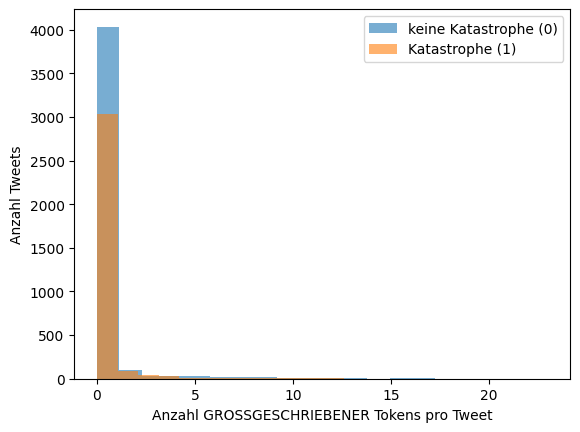

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt

UPPER_TOKEN_RE = re.compile(r"^[A-ZÄÖÜ]{2,}$")

def count_uppercase_tokens(text):
    tokens = str(text).split()
    return sum(1 for t in tokens if UPPER_TOKEN_RE.match(t))

df_dist = df.copy()
df_dist["upper_token_count"] = df_dist["text"].apply(count_uppercase_tokens)

# Split nach Klasse
cnt_0 = df_dist[df_dist["target"] == 0]["upper_token_count"]
cnt_1 = df_dist[df_dist["target"] == 1]["upper_token_count"]

# Plot
plt.figure()
plt.hist(cnt_0, bins=20, alpha=0.6, label="keine Katastrophe (0)")
plt.hist(cnt_1, bins=20, alpha=0.6, label="Katastrophe (1)")
plt.xlabel("Anzahl GROSSGESCHRIEBENER Tokens pro Tweet")
plt.ylabel("Anzahl Tweets")
plt.legend()
plt.show()

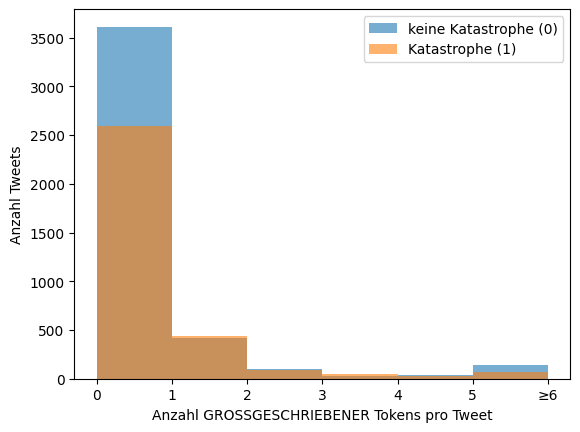

In [ ]:
def clip_counts(s, max_val=5):
    return s.clip(upper=max_val)

plt.figure()
plt.hist(clip_counts(cnt_0), bins=range(0,7), alpha=0.6, label="keine Katastrophe (0)")
plt.hist(clip_counts(cnt_1), bins=range(0,7), alpha=0.6, label="Katastrophe (1)")

plt.xticks(range(0,7), ["0","1","2","3","4","5","≥6"])
plt.xlabel("Anzahl GROSSGESCHRIEBENER Tokens pro Tweet")
plt.ylabel("Anzahl Tweets")
plt.legend()
plt.show()